In [226]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet
import collections
from collections import Counter

In [227]:
#df = pd.read_csv('./merged.csv')
df = pd.read_csv('./Alumni Dataset.csv', error_bad_lines=False)

#df = pd.read_csv('./final_Nov_09.csv')

df.shape

C:\Users\basha\.conda\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





(4703, 12)

In [228]:
df.head()

,Unnamed: 0,Name,Current_Company,Current_Job,Experience,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills
0,0,abrar javed,upwork,professional freelancer,1,pakistan,bs electrical engineering,2015,2020,fast nuces,/in/abrar-javed-49854b14b/,"management,microsoft excel,customer service,st..."
1,1,mahrukh fatima,devbunch private limited,project coordinator,1,lahore pakistan,bachelor of business administration (bba),2014,2018,fast nuces,/in/mahrukh-fatima-60b863106/,"microsoft office,customer service,microsoft ex..."
2,2,neha nadeem,daraz,data analyst,1,united states,bachelor of science in computer science,2016,2020,fast nuces,/in/nehanadeem/,"business intelligence (bi),data analysis,data ..."
3,3,abdul rafeh,no joke marketing,corporate marketing manager,1,united states,master's degree,2017,2018,fast nuces,/in/rafeh11/,"microsoft office,microsoft excel,powerpoint,re..."
4,4,areeba ayyaz,keeptruckin,Software engineer,1,lahore pakistan,bachelor of science in computer science,2016,2020,fast nuces,/in/areeba-ayyaz-6948071a3/,"java,ruby on rails,problem solving,android dev..."


# Handling Missing Values:


In [229]:
# % of values missing in each column
values_list = list()
cols_list = list()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())*100
    cols_list.append(col)
    values_list.append(pct_missing)
pct_missing_df = pd.DataFrame()
pct_missing_df['col'] = cols_list
pct_missing_df['pct_missing'] = values_list
pct_missing_df['pct_missing']

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.063789
Name: pct_missing, dtype: float64

In [230]:
df["Graduation_start_year"] = pd.to_numeric(df["Graduation_start_year"], errors='coerce').fillna(0, downcast='infer')
df["Graduation_end_year"] = pd.to_numeric(df["Graduation_end_year"], errors='coerce').fillna(0, downcast='infer')
df["Experience"] = pd.to_numeric(df["Experience"], errors='coerce').fillna(0, downcast='infer')

In [231]:
df.dtypes

Unnamed: 0                int64
Name                     object
Current_Company          object
Current_Job              object
Experience                int64
job_location             object
Last_degree              object
Graduation_start_year     int64
Graduation_end_year       int64
Last_University          object
ProfileIDS               object
skills                   object
dtype: object

In [232]:
#we will replace missing values with the mode values of that column.
df_non_numeric = df.select_dtypes(exclude=[np.number]) 
non_numeric_cols = df_non_numeric.columns.values
for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        mod = df[col].describe()['top'] # impute with the most frequently occuring value
        df[col] = df[col].fillna(mod)

#we will replace missing values with the median values of that column.
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        med = df[col].median() #impute with the median
        df[col] = df[col].fillna(med)
df.isnull().sum().sum()

0

# Duplicate records

In [233]:
# dropping duplicate profile urls from  ProfileIDS Column
profile_urls = list(df.columns)[-2]
df.drop_duplicates(subset=profile_urls, inplace=True)
df.shape

(4703, 12)

In [234]:
df['Name'] = df['Name'].str.lower()
df['Name'] = df['Name'].str.strip()
df['Current_Company'] = df['Current_Company'].str.lower()
df['Current_Company'] = df['Current_Company'].str.strip()
df['Current_Job'] = df['Current_Job'].str.lower()
df['Current_Job'] = df['Current_Job'].str.strip()
df['job_location'] = df['job_location'].str.lower()
df['job_location'] = df['job_location'].str.strip()
df['Last_degree'] = df['Last_degree'].str.lower()
df['Last_degree'] = df['Last_degree'].str.strip()
df['Last_University'] = df['Last_University'].str.lower()
df['Last_University'] = df['Last_University'].str.strip()
df['skills'] = df['skills'].str.lower()
df['skills'] = df['skills'].str.strip()

# Correcting Inconsistencies

In [235]:
#There were many different words in the responses which referred to the same term, so we grouped them in a single word.
#Typos and mis-spelling were corrected.
#Finally, punctuation such as commas, apostrophes, quotes, question marks and others was removed.

## Skills columns

In [236]:
df['skills'] = df['skills'].apply(lambda x: x.replace("||", ","))

## Last_University & Current_Company


In [237]:
df['Last_University'] = df['Last_University'].apply(lambda x: x.replace("national university of computer and emerging sciences", "fast nuces"))
df['Current_Company'] = df['Current_Company'].apply(lambda x: x.replace("national university of computer and emerging sciences", "fast nuces"))


In [238]:
df

,Unnamed: 0,Name,Current_Company,Current_Job,Experience,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills
0,0,abrar javed,upwork,professional freelancer,1,pakistan,bs electrical engineering,2015,2020,fast nuces,/in/abrar-javed-49854b14b/,"management,microsoft excel,customer service,st..."
1,1,mahrukh fatima,devbunch private limited,project coordinator,1,lahore pakistan,bachelor of business administration (bba),2014,2018,fast nuces,/in/mahrukh-fatima-60b863106/,"microsoft office,customer service,microsoft ex..."
2,2,neha nadeem,daraz,data analyst,1,united states,bachelor of science in computer science,2016,2020,fast nuces,/in/nehanadeem/,"business intelligence (bi),data analysis,data ..."
3,3,abdul rafeh,no joke marketing,corporate marketing manager,1,united states,master's degree,2017,2018,fast nuces,/in/rafeh11/,"microsoft office,microsoft excel,powerpoint,re..."
4,4,areeba ayyaz,keeptruckin,software engineer,1,lahore pakistan,bachelor of science in computer science,2016,2020,fast nuces,/in/areeba-ayyaz-6948071a3/,"java,ruby on rails,problem solving,android dev..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4698,4698,nust uni,fast nuces,software engineer,1,lahore pakistan,bachelor's degree,2016,2016,fast nuces,/in/nust-uni-181a20162/,"c,java,html,programming,software development,o..."
4699,4699,shayan ahmad,playtech,java developer,1,"london, england, united kingdom",bachelor of science (bs),2012,2016,fast nuces,/in/yansha/,"c++,c,embedded c,object-oriented programming (..."
4700,4700,hamza sheikh,eers global technologies inc.,advanced embedded developer,2,canada,master of engineering - meng,2018,2019,queen's university - faculty of engineering an...,/in/hamzasheikh876/,"communication,design,front end development,ana..."
4701,4701,fizza surahio,wavetec,software quality assurance,1,karachi pakistan,bachelor's degree,2018,2021,fast nuces,/in/fizza-surahio-3143511b3/,"python,data science,machine learning,research,..."


## Last_degree


In [25]:
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bs", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("ms", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("mphil", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("cs", "computer science"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("conputer", "computer"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("(ee)", "electrical engineering"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("(te)", "electrical engineering"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("(af)", "business adminintration"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelor's", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelora's degree", "bachelor"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelor’s", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelors", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("b.s", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bba", "bachelor of business adminintration"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("mastera's", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("master's", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("master’s degree", "master"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("masters", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("phd", "doctor of philosophy"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("mba", "master of business adminintration"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("accounting and finance", "business adminintration"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("spm", "software project management"))


df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor of computer science' if 'bachelor' in x and 'computer' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor electrical engineering' if 'bachelor' in x and 'electrical' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor electrical engineering' if 'bachelor' in x and 'telecommunication' in x else x) 

df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor of business administration' if 'bachelor' in x and 'administration' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor of business administration' if 'bachelor' in x and 'finance' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'master of computer science' if 'master' in x and 'computer' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'master of computer science' if 'master' in x and 'technology' in x else x)

df.Last_degree = df.Last_degree.apply(lambda x: 'master of business administration' if 'master' in x and 'administration' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'master of software project management' if 'master' in x and 'project' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'doctor of philosophy' if 'postgradua' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'doctor of philosophy' if 'doctor' in x else x)



df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*electrical.*$)','bachelor electrical engineering')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*administration.*$)','bachelor of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*finance.*$)','bachelor of business administration')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*administration.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and'(^.*computer.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and'(^.*technology.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and'(^.*project.*$)', 'master of software project management')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*postgradua.*$)'or'(^.*philoso.*$)', 'doctor of philosophy')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*doctor.*$)', 'doctor of philosophy')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*engineering.*$)', 'bachelor of electrical engineering')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor of science.*$)'or "(^.*bachelora's degree.*$)", 'bachelor degree')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*administration.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*business.*$)'or '(^.*finance.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*information.*$)'or '(^.*technology.*$)'or '(^.*comput.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*masters of science.*$)'or '(^.*master in science.*$)', 'master degree')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*project .*$)', 'master of project managment')


df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*engineering.*$)', 'bachelor of electrical engineering')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor of science.*$)'or "(^.*bachelora's degree.*$)", 'bachelor degree')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*administration.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*business.*$)'or '(^.*finance.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*information.*$)'or '(^.*technology.*$)'or '(^.*comput.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*masters of science.*$)'or '(^.*master in science.*$)', 'master degree')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*project .*$)', 'master of project managment')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master of science.*$)', 'master degree')

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2032835493.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2032835493.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*electrical.*$)','bachelor electrical engineering')
C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2032835493.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*administration.*$)','bachelor of business administration')
C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2032835493.py:49: FutureWarning: The default value of regex will change from Tru

## job_location


In [239]:
df['job_location'] = df.job_location.str.replace(r'(^.*lahore.*$)', 'lahore pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*faisalabad.*$)', 'faisalabad Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*multan.*$)', 'multan Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*sialkot.*$)', 'sialkot Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*gilgit.*$)', 'gilgit Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*kar.*$)', 'karachi pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*islam.*$)', 'islamabad pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*rawalpindi.*$)', 'islamabad pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*quetta.*$)', 'quetta pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*united states.*$)', 'united states')
df['job_location'] = df.job_location.str.replace(r'(^.*canada.*$)', 'canada')
df['job_location'] = df.job_location.str.replace(r'(^.*peshawar.*$)'or'(^.*khyber pakhtunkhwa.*$)' , 'peshawar') 
df['job_location'] = df.job_location.str.replace(r'(^.*khyber pakhtunkhwa.*$)' , 'peshawar')
df.Last_degree = df.Last_degree.apply(lambda x: 'pakistan' if 'pakistan' in x and  'peshawar' != x and  'lahore' != x and  'faisalabad' != x and  'karachi' != x and  'rawalpindi' != x and  'quetta' != x and  'islam' != x and  'sialkot' != x and  'multan' != x and  'karachi' != x and  'rawalpindi' != x and  'quetta' != x else x)


C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2563685280.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2563685280.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2563685280.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2563685280.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2563685280.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/2563685280.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\basha\AppData\Local

In [240]:
df.head(60)

,Unnamed: 0,Name,Current_Company,Current_Job,Experience,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills
0,0,abrar javed,upwork,professional freelancer,1,pakistan,bs electrical engineering,2015,2020,fast nuces,/in/abrar-javed-49854b14b/,"management,microsoft excel,customer service,st..."
1,1,mahrukh fatima,devbunch private limited,project coordinator,1,lahore pakistan,bachelor of business administration (bba),2014,2018,fast nuces,/in/mahrukh-fatima-60b863106/,"microsoft office,customer service,microsoft ex..."
2,2,neha nadeem,daraz,data analyst,1,united states,bachelor of science in computer science,2016,2020,fast nuces,/in/nehanadeem/,"business intelligence (bi),data analysis,data ..."
3,3,abdul rafeh,no joke marketing,corporate marketing manager,1,united states,master's degree,2017,2018,fast nuces,/in/rafeh11/,"microsoft office,microsoft excel,powerpoint,re..."
4,4,areeba ayyaz,keeptruckin,software engineer,1,lahore pakistan,bachelor of science in computer science,2016,2020,fast nuces,/in/areeba-ayyaz-6948071a3/,"java,ruby on rails,problem solving,android dev..."
5,5,ram chand,upwork,machine learning engineer,1,pakistan,bachelor of science in computer science,2016,2020,fast nuces,/in/ram-chand-57ab41133/,"project management,artificial intelligence,mac..."
6,6,farooq sarfraz,emeritus,subject matter expert,1,united states,masters of data analytics,2018,2020,deakin university,/in/farooq-sarfraz-457a591a8/,"data analytics,php frameworks,analytics,progra..."
7,7,areij javed,ibm,data scientist,2,"islamabad, pakistan",master's degree,2017,2018,the australian national university,/in/areij-javed-820795b4/,"computer science,artificial intelligence,progr..."
8,8,muhammad ashir,nextbridge ltd.,associate software engineer,1,lahore pakistan,bachelor's degree,2016,2020,fast nuces,/in/muhammadashirali4/,"software development,android development,flutt..."
9,9,wajahat shaw,upwork,sr. react native developer,3,islamabad,specialization in full stack development with ...,2019,2019,harvard university,/in/wajahat-shaw-676963ba/,"react native,react.js,node.js,analytical skill..."


In [241]:
df.shape

(4703, 12)

In [242]:
# get all the unique values in the 'City' column
Current_Job = df['Current_Job'].unique()

# sort them alphabetically and then take a closer look

len(Current_Job)# get all the unique values in the 'City' column
Current_Job = df['Current_Job'].unique()

# sort them alphabetically and then take a closer look

len(Current_Job)

1696

In [243]:
jobs = ['Software engineer', 'Software Developer',
'freelancer',
'Full-stack developer',
'Front end developer','Back end developer','Blockchain Engineer','Cloud Architect','Java developer','DevOps engineer',
'UX designer',
'Web Developer',
'Security Analyst',
'Project Manager',
'Data scientist',
'data analyst','Data Engineer',
'Business analyst',
'Robotics Engineer',
'Cloud computing engineer',
'Software quality assurance',
'machine learning engineer',
'AI Engineer',
'Mobile App Developer', 
'Game Developer',
'Computer Programmer',
'Database Administrator',
'Computer Network Architect',
'Network Administrator',
'Information Researcher',
]

In [244]:
def find_min_ratio(matches):
    list_of_jobs = []
    for i in matches:
        if i[1] > 70 and i[1] < 100:
            list_of_jobs.append(i[1])
    if len(list_of_jobs) == 0 or len(list_of_jobs) == 1:
        return 0
    else: 
        list_of_jobs = Counter(list_of_jobs)
        common_elements = list_of_jobs.most_common(5)
        last_tuple = min(common_elements,key=lambda item:(-item[1], item[0]))
        min_ratio = last_tuple[0]
        return min_ratio
    
def replace_matches_in_column(matches, string_to_match, df, column, min_ratio = 70):
    strings = df[column].unique()
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = df[column].isin(close_matches)

    df.loc[rows_with_matches, column] = string_to_match
    
def replace_matches_in_column(matches, string_to_match, df, column, min_ratio = 70):
    strings = df[column].unique()
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = df[column].isin(close_matches)

    df.loc[rows_with_matches, column] = string_to_match
    
    
loc=df['Current_Job'].unique()
len(loc)


1696

In [245]:
df

,Unnamed: 0,Name,Current_Company,Current_Job,Experience,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills
0,0,abrar javed,upwork,professional freelancer,1,pakistan,bs electrical engineering,2015,2020,fast nuces,/in/abrar-javed-49854b14b/,"management,microsoft excel,customer service,st..."
1,1,mahrukh fatima,devbunch private limited,project coordinator,1,lahore pakistan,bachelor of business administration (bba),2014,2018,fast nuces,/in/mahrukh-fatima-60b863106/,"microsoft office,customer service,microsoft ex..."
2,2,neha nadeem,daraz,data analyst,1,united states,bachelor of science in computer science,2016,2020,fast nuces,/in/nehanadeem/,"business intelligence (bi),data analysis,data ..."
3,3,abdul rafeh,no joke marketing,corporate marketing manager,1,united states,master's degree,2017,2018,fast nuces,/in/rafeh11/,"microsoft office,microsoft excel,powerpoint,re..."
4,4,areeba ayyaz,keeptruckin,software engineer,1,lahore pakistan,bachelor of science in computer science,2016,2020,fast nuces,/in/areeba-ayyaz-6948071a3/,"java,ruby on rails,problem solving,android dev..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4698,4698,nust uni,fast nuces,software engineer,1,lahore pakistan,bachelor's degree,2016,2016,fast nuces,/in/nust-uni-181a20162/,"c,java,html,programming,software development,o..."
4699,4699,shayan ahmad,playtech,java developer,1,"london, england, united kingdom",bachelor of science (bs),2012,2016,fast nuces,/in/yansha/,"c++,c,embedded c,object-oriented programming (..."
4700,4700,hamza sheikh,eers global technologies inc.,advanced embedded developer,2,canada,master of engineering - meng,2018,2019,queen's university - faculty of engineering an...,/in/hamzasheikh876/,"communication,design,front end development,ana..."
4701,4701,fizza surahio,wavetec,software quality assurance,1,karachi pakistan,bachelor's degree,2018,2021,fast nuces,/in/fizza-surahio-3143511b3/,"python,data science,machine learning,research,..."


In [246]:
Education = pd.DataFrame(df)
Edu_data =Education[['Name','Last_degree','Last_University','ProfileIDS']]
Edu_data

,Name,Last_degree,Last_University,ProfileIDS
0,abrar javed,bs electrical engineering,fast nuces,/in/abrar-javed-49854b14b/
1,mahrukh fatima,bachelor of business administration (bba),fast nuces,/in/mahrukh-fatima-60b863106/
2,neha nadeem,bachelor of science in computer science,fast nuces,/in/nehanadeem/
3,abdul rafeh,master's degree,fast nuces,/in/rafeh11/
4,areeba ayyaz,bachelor of science in computer science,fast nuces,/in/areeba-ayyaz-6948071a3/
...,...,...,...,...
4698,nust uni,bachelor's degree,fast nuces,/in/nust-uni-181a20162/
4699,shayan ahmad,bachelor of science (bs),fast nuces,/in/yansha/
4700,hamza sheikh,master of engineering - meng,queen's university - faculty of engineering an...,/in/hamzasheikh876/
4701,fizza surahio,bachelor's degree,fast nuces,/in/fizza-surahio-3143511b3/


In [247]:
#Creating column to identify degree earned

edu = Edu_data

# Function to identify degree
def degree(x):
    if x.find('bachelor') != -1 or x.find("bachelor's") != -1 or x.find('bs') != -1 or x.find('bs ') != -1 or x.find('bs') != -1 or x.find('bachelors') != -1 or x.find('undergraduate') != -1 or x.find('graduated')!= -1 or x.find('bse')!= -1 or x.find('enginee') != -1 or x.find('bcs') != -1:
        return(1)
    if x.find('master') != -1 or x.find("master's") != -1 or x.find('m.s') != -1 or x.find('ms') != -1 or x.find('mphil') != -1 or x.find('mba') != -1 or x.find('micromasters') != -1 or x.find('msc') != -1 or x.find('mscs') !=-1 or x.find('msds')!=-1or x.find('master of engineering') != -1:
        return(2)
    if x.find('phd') != -1 or x.find('p.hd') != -1 or x.find('ph.d') != -1 or x.find('ph.d') != -1:
        return(3)
    else:
        return(0)

    
# Create degree column
#edu['deg'] = list(map(degree, edu['Last_degree']))
edu['deg'] = list(map(degree, edu['Last_degree'].astype(str)))

edu

C:\Users\basha\AppData\Local\Temp/ipykernel_6192/742958102.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Last_degree,Last_University,ProfileIDS,deg
0,abrar javed,bs electrical engineering,fast nuces,/in/abrar-javed-49854b14b/,1
1,mahrukh fatima,bachelor of business administration (bba),fast nuces,/in/mahrukh-fatima-60b863106/,1
2,neha nadeem,bachelor of science in computer science,fast nuces,/in/nehanadeem/,1
3,abdul rafeh,master's degree,fast nuces,/in/rafeh11/,2
4,areeba ayyaz,bachelor of science in computer science,fast nuces,/in/areeba-ayyaz-6948071a3/,1
...,...,...,...,...,...
4698,nust uni,bachelor's degree,fast nuces,/in/nust-uni-181a20162/,1
4699,shayan ahmad,bachelor of science (bs),fast nuces,/in/yansha/,1
4700,hamza sheikh,master of engineering - meng,queen's university - faculty of engineering an...,/in/hamzasheikh876/,1
4701,fizza surahio,bachelor's degree,fast nuces,/in/fizza-surahio-3143511b3/,1


In [248]:
#Gathering only the employee's last completed education before employment 

eduF = Edu_data.groupby('ProfileIDS').first()
#eduF

In [249]:
#Looking into the percentages of each last degree earned 

eduF['deg'].value_counts(normalize=True) * 100
#eduF['deg'].unique()

1    54.858601
2    35.785669
0     7.229428
3     2.126302
Name: deg, dtype: float64

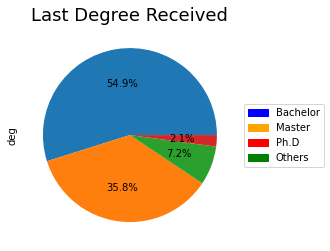

In [250]:
pie = eduF['deg'].value_counts().plot(kind="pie", autopct='%1.1f%%', labels=None)

pie.set_title("Last Degree Received", fontsize=18)
Bachelor = mpatches.Patch(color='blue', label='Bachelor')
Master = mpatches.Patch(color='orange', label='Master')
Other = mpatches.Patch(color='green', label='Others')
PhD = mpatches.Patch(color='red', label='Ph.D')
plt.legend(handles=[Bachelor,Master,PhD,Other], loc='center left', bbox_to_anchor=(1, 0.5))

In [251]:
eduF['deg'].value_counts(normalize=True)

1    0.548586
2    0.357857
0    0.072294
3    0.021263
Name: deg, dtype: float64

In [252]:
edu_counts= eduF['deg'].value_counts()
edu_counts

1    2580
2    1683
0     340
3     100
Name: deg, dtype: int64

In [257]:
import plotly.express as px
edu_counts= eduF['deg'].value_counts()
fig = px.bar(
    edu_counts, 
    title="Education Level of Respondents",
    orientation="v"
    #rotation=90
)
fig.update_layout(
    xaxis_title = "Frequency",
    yaxis_title = "Education Level",
    title_x = 0.5,
    showlegend = False
)
fig.show()

In [258]:
#Remove degrees Not bachelor 
edub = edu
edub = edub[edub.deg != 0]
edub = edub[edub.deg != 2]
edub = edub[edub.deg != 3]
#edub

In [259]:
# Function to identify Bachelor degree name

def degN(x):
    if x.lower().find('computer') != -1 or x.lower().find('science') != -1 or x.lower().find('bs(cs)') != -1 or x.lower().find('bcs') != -1 or x.lower().find('cs') != -1 or x.lower().find('bs(te)')!= -1:
        return(1)
    if x.lower().find('bs electrical engineering') != -1 or x.lower().find('elect') != -1 or x.lower().find('ee') != -1:
        return(2)
    if x.lower().find('finan') != -1 or x.lower().find('bba') != -1 or x.lower().find('market') != -1 or x.lower().find('business') != -1 or x.lower().find('accounting and finance') != -1 or x.lower().find('bs-af')!= -1:
        return(3)
    if x.lower().find('civil engineering') != -1 or x.lower().find('bs (civil engineering)') != -1 or x.lower().find('civil') != -1:
        return(4)
    if x.lower().find('math') != -1 or x.find('applied Science') != -1 or x.lower().find('math') != -1:
        return(5)
    else:
        return(0)

    
# Create degree column
edub['deg_name'] = list(map(degN, edub['Last_degree']))

#Took out values = 0 because they are only gpa scores 
edub = edub[edub.deg_name != 0]

#edub

In [260]:
#pd.set_option("max_rows", None)
#edub
edub['deg_name'].value_counts(normalize=True) * 100

1    47.161758
2    45.070423
3     7.767819
Name: deg_name, dtype: float64

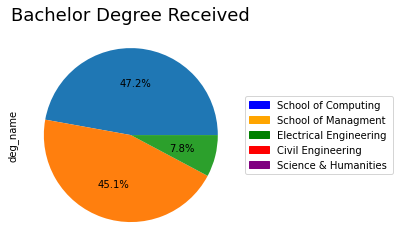

In [261]:
pie8 = edub['deg_name'].value_counts().plot(kind="pie", autopct='%1.1f%%', labels=None)

pie8.set_title("Bachelor Degree Received", fontsize=18)

ComputerScience = mpatches.Patch(color='blue', label='School of Computing')
BusinessAdministration = mpatches.Patch(color='orange', label='School of Managment')
ElectricalEngineering  = mpatches.Patch(color='green', label='Electrical Engineering ')
CivilEngineering = mpatches.Patch(color='red', label='Civil Engineering')
Science_and_Humanities = mpatches.Patch(color='purple', label='Science & Humanities')

plt.legend(handles=[ComputerScience,BusinessAdministration,ElectricalEngineering,CivilEngineering,Science_and_Humanities], loc='center left', bbox_to_anchor=(1, 0.5))

In [268]:
df

,Name,Current_Company,Current_Job,Experience,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills
0,abrar javed,upwork,professional freelancer,1,pakistan,bs electrical engineering,2015,2020,fast nuces,/in/abrar-javed-49854b14b/,"management,microsoft excel,customer service,st..."
1,mahrukh fatima,devbunch private limited,project coordinator,1,lahore pakistan,bachelor of business administration (bba),2014,2018,fast nuces,/in/mahrukh-fatima-60b863106/,"microsoft office,customer service,microsoft ex..."
2,neha nadeem,daraz,data analyst,1,united states,bachelor of science in computer science,2016,2020,fast nuces,/in/nehanadeem/,"business intelligence (bi),data analysis,data ..."
3,abdul rafeh,no joke marketing,corporate marketing manager,1,united states,master's degree,2017,2018,fast nuces,/in/rafeh11/,"microsoft office,microsoft excel,powerpoint,re..."
4,areeba ayyaz,keeptruckin,software engineer,1,lahore pakistan,bachelor of science in computer science,2016,2020,fast nuces,/in/areeba-ayyaz-6948071a3/,"java,ruby on rails,problem solving,android dev..."
...,...,...,...,...,...,...,...,...,...,...,...
4698,nust uni,fast nuces,software engineer,1,lahore pakistan,bachelor's degree,2016,2016,fast nuces,/in/nust-uni-181a20162/,"c,java,html,programming,software development,o..."
4699,shayan ahmad,playtech,java developer,1,"london, england, united kingdom",bachelor of science (bs),2012,2016,fast nuces,/in/yansha/,"c++,c,embedded c,object-oriented programming (..."
4700,hamza sheikh,eers global technologies inc.,advanced embedded developer,2,canada,master of engineering - meng,2018,2019,queen's university - faculty of engineering an...,/in/hamzasheikh876/,"communication,design,front end development,ana..."
4701,fizza surahio,wavetec,software quality assurance,1,karachi pakistan,bachelor's degree,2018,2021,fast nuces,/in/fizza-surahio-3143511b3/,"python,data science,machine learning,research,..."


In [270]:
df.to_csv('Alumni final dataset.csv', index=False)
